# 44-wav-embedding-experiments-dev
> A notebook for code development for experimenting with embeddings and clustering

In this notebook, we develop some code for general use for clustering of generated embeddings for similarities.

In [ ]:
#default_exp audio_embedding_viz
#all_no_test

In [ ]:
#export
#data science packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#umap
import umap
import umap.plot

#scikit learn helpers
from sklearn.cluster import KMeans

#other python packages
import os.path
import glob
import string
import re
import ast

In [ ]:
#for interactivity on 3D plots, use notebook
#%matplotlib notebook
%matplotlib inline

# Load embedding data
Here, we'll load the csvs with all of the embedding data generated in the 42 notebook.  Note that the currently saved format is csv, meaning that we lose the format of the list/array.  Instead, this is read in as a literal.  We'll use the `ast` package and the `converters` keyword to apply the conversion of this huge string literal to a list datatype.

In [ ]:
# base file path on accre
base_prefix = os.path.expanduser('/data/p_dsi/wise/data/embedding_csv/')

In [ ]:
# get list of resampled audio files
audio_files_list = glob.glob(base_prefix + '*.csv')

#Load list of csvs as lists of dataframes
embeddings_dfs = [pd.read_csv(csv_file, sep=',', converters={'last_hidden_state_mean':ast.literal_eval})
                  for csv_file in audio_files_list]

In [ ]:
#Inspect one
embeddings_dfs[0].head()

,id,transcript_filepath,wave_filename,speech,start_timestamp,end_timestamp,label,transcriber_id,last_hidden_state,last_hidden_state_mean,shape_state,start_milliseconds,end_milliseconds,length in seconds
0,134-1,~/Box Sync/DSI Documents/cleaned_data/cleaned_...,~/Box Sync/DSI Documents/Audio Files & Tanscri...,good.,00:02.164,00:03.250,PRS,198,"[[-0.04940829798579216, 0.022830531001091003, ...","[-0.008398409001529217, 0.03857032582163811, -...","(54, 768)",2164,3250,1.086
1,134-1,~/Box Sync/DSI Documents/cleaned_data/cleaned_...,~/Box Sync/DSI Documents/Audio Files & Tanscri...,what's this word.,00:03.250,00:04.014,OTR,198,"[[0.16693411767482758, -0.08026503026485443, -...","[0.04827310889959335, 0.007540498394519091, -0...","(37, 768)",3250,4014,0.764
2,134-1,~/Box Sync/DSI Documents/cleaned_data/cleaned_...,~/Box Sync/DSI Documents/Audio Files & Tanscri...,SEE spells~,00:06.308,00:08.170,OTR,198,"[[0.021181466057896614, 0.03635687753558159, -...","[-0.040786080062389374, 0.023049458861351013, ...","(92, 768)",6308,8170,1.862
3,134-1,~/Box Sync/DSI Documents/cleaned_data/cleaned_...,~/Box Sync/DSI Documents/Audio Files & Tanscri...,what do you do with your eyes.,00:08.170,00:10.371,OTR,198,"[[-0.02607142925262451, 0.01225950662046671, 0...","[-0.013341954909265041, 0.0059876823797822, -0...","(109, 768)",8170,10371,2.201
4,134-1,~/Box Sync/DSI Documents/cleaned_data/cleaned_...,~/Box Sync/DSI Documents/Audio Files & Tanscri...,see.,00:12.000,00:13.473,NEU,198,"[[-0.02545803226530552, 0.05385156348347664, -...","[-0.04408932477235794, 0.021641386672854424, -...","(73, 768)",12000,13473,1.473


In [ ]:
#combine into huge df
embed_df = pd.concat(embeddings_dfs)
display(embed_df.head(3))
embed_df.shape

,id,transcript_filepath,wave_filename,speech,start_timestamp,end_timestamp,label,transcriber_id,last_hidden_state,last_hidden_state_mean,shape_state,start_milliseconds,end_milliseconds,length in seconds,Notes,Jess Labels,Unnamed: 9,Unnamed: 8,Notes - what I would code as
0,134-1,~/Box Sync/DSI Documents/cleaned_data/cleaned_...,~/Box Sync/DSI Documents/Audio Files & Tanscri...,good.,00:02.164,00:03.250,PRS,198,"[[-0.04940829798579216, 0.022830531001091003, ...","[-0.008398409001529217, 0.03857032582163811, -...","(54, 768)",2164,3250,1.086,NaN,NaN,NaN,NaN,NaN
1,134-1,~/Box Sync/DSI Documents/cleaned_data/cleaned_...,~/Box Sync/DSI Documents/Audio Files & Tanscri...,what's this word.,00:03.250,00:04.014,OTR,198,"[[0.16693411767482758, -0.08026503026485443, -...","[0.04827310889959335, 0.007540498394519091, -0...","(37, 768)",3250,4014,0.764,NaN,NaN,NaN,NaN,NaN
2,134-1,~/Box Sync/DSI Documents/cleaned_data/cleaned_...,~/Box Sync/DSI Documents/Audio Files & Tanscri...,SEE spells~,00:06.308,00:08.170,OTR,198,"[[0.021181466057896614, 0.03635687753558159, -...","[-0.040786080062389374, 0.023049458861351013, ...","(92, 768)",6308,8170,1.862,NaN,NaN,NaN,NaN,NaN


(1450, 19)

As expected, we can see that we have all the data in terms of descriptive information alongside the mean embeddings.  We can concatenate this into one big dataframe and use this henceforth.  It looks like we have 1450 audio subsegments with which to work.

# Embeddings as numpy arrays
We'll just quickly get a numpy array of the mean embeddings so we can easily use this directly.

In [ ]:
embeds = np.array(embed_df['last_hidden_state_mean'].tolist())
embeds.shape

(1450, 768)

Great, the perfect dimensions.

# UMAP for dimensionality reduction
Here, we can use UMAP to reduce the dimensions of the data for faster computation or more consolidated information, removing extraneous chaff.  We can essentially pick any dimension <= 768 (the size of the embedding layer), but we've seen that at least 2 dimensions is helpful.

To learn more about the outputs of the umap package, the 42 notebook has great details about this.

## Plotting Helpers
In this section, we're going to develop some code which will help us quickly visualize some behavior of the unsupervised UMAP clusters, and 42 contains the motivation for which this code was derived.  An overview is provided thusly:
* **get_umap_fit**: This function basically does any fitting and allows for setting of desired parameters of umap.  It will generate the fit and return this.  There are many options regarding what can be plotted.  This is the highest-level function which should generally be used.  This function calls the following function to produce a panel 2D projections of the first 3 dimensions.  One or more colors can be selected to identify the clusters.


* **show_umap_dims**:  This is a mid-level function which allows us to see 2D projections of the first 3 UMAP dimensions, with options for the colors to be overlaid on the transformed points.  The objective here is to create a panel of projection subplots for a given color.  However, each subplot has almost the same exact code required to show it.  This leads to the next function:


* **\_umap_plt_displays**: This function plots any single plot of the subplots, where one of the inputs describes the subplot number, and the axes to be plotted.

More details are in the docstrings and described below.

### Define a function to run different parameters (tune the umap model to best separate clusters)

In [ ]:
#export
def get_umap_fit(data_df, fit=None, n_neighbors=15, min_dist=0.1, n_components=3, 
                 metric='euclidean', random_state=1234,
                 show_plots='2d', color_by='all', figsize=(14,6)):
    '''
    Function get_umap_fit: performs dimensionality reduction on embeddings using UMAP and optionally plots first 3 dimensions and/or 3d plot colored by labels of interest
        data_df: dataframe with minimally columns 'label', 'teacher', 'length', and 'last_hidden_state_mean'
        fit (default None): UMAP fit object; used if a new computation isn't necessary and only the plots are desired
        n_neighbors (default 15): integer for number of neighbors for UMAP
        min_dist (default 0.1): float of minimum separation for UMAP
        n_components (default 3): minimum number of components allowed for UMAP dimensionality reduction
        metric (default 'euclidean'): string of distance measure for UMAP
        random_state (default 1234): random number generator setting for reproducibility
        show_plots (default '2d'): string of types of plots to show - can be any one of '2d', '3d', or 'all'
        color_by (default 'all'): string of column name for columns to show.  Currently accepts 'label', 'teacher', 'length', or 'all'
        figsize (default (14,6)): tuple of width, height of individual figure
        
        Returns: UMAP fit object
        
    '''
    
    if fit is None:
        # Create the data as numpy array
        data = np.array(data_df['last_hidden_state_mean'].tolist())

        # Make UMAP specifications
        fit_spec = umap.UMAP(
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            n_components=n_components,
            metric=metric,
            random_state=random_state
        )

        # Generate the fit
        fit = fit_spec.fit(data)
    
    # Determine plots to be made
    if color_by == 'all':
        color_by_list = ['label', 'teacher', 'length']
    else:
        color_by_list = [color_by]
    
    # Show plots if desired
    if show_plots is not None:
        
        if show_plots == '2d' or show_plots == 'all':
            [show_umap_dims(fit, data_df, color_by, plot_3d=False, figsize=figsize) for color_by in color_by_list]
            
        if show_plots == '3d' or show_plots=='all':
            [show_umap_dims(fit, data_df, color_by, plot_3d=True, figsize=figsize) for color_by in color_by_list]
    
    # Return fit
    return fit

The following function plots all 3 dimensions (or a 3d plot) for any given `color_by` column name input.  As shown in the calling `get_umap_fit` function above, it is called once for any value in `color_by`.  The following function plots both categorical and continuous values of color which results in a bit of complexity in establishing the colors and plot parameters.  An additional source of complexity is the usage of an anonymization of teacher IDs using letters of the alphabet.

In [ ]:
#export
def show_umap_dims(fit, data_df, color_by='label', plot_3d=False, figsize=(12,4)):
    '''
    Function show_umap_dims: Generates three 2D plots for first 3 dimensions or a 3d plot with points colored based on color_by
        fit: UMAP fit object
        data_df: dataframe with minimally column names 'label', 'length in seconds', 'id'
        color_by (default 'label'): string of column to color points by. Accepted values are 'label', 'length', and 'teacher'
        plot_3d (default False): boolean of whether to plot the 3d plot
        figsize (default (12,4)): tuple of size of plots
        
        Returns: nothing; shows three 2D plots or a 3D plot, colored by column 'color_by'
    '''

    # Determine display
    kwargs = {'cmap':'tab10'}
    if color_by == 'label':
        
        # Generate a color mapping dictionary
        label_list = ['PRS', 'REP', 'NEU', 'OTR', 'OT']
        int_list = [0, 1, 2, 3, 3]
        color_dict = dict(zip(label_list, int_list))
        
        # Determine color
        color = data_df['label'].replace(color_dict)
    
    elif color_by == 'length':
        color = data_df['length in seconds']
        label_list = None
        kwargs = {'cmap':'viridis', 'vmin':0, 'vmax':10}
        
    elif color_by == 'teacher':
        teach_ids = data_df['id'].apply(lambda x: x.split('-')[0])
        
        # Anonymize teacher IDs
        label_ids = teach_ids.unique().tolist()
        int_list = list(range(len(label_ids)))
        label_list = list(string.ascii_uppercase)[:len(int_list)]
        anon_ids_list = dict(zip(label_ids, label_list))
        print(anon_ids_list)
        
        #determine color
        color_dict = dict(zip(label_ids, int_list))
        color = teach_ids.replace(color_dict)
    else:
        ValueError("Whoops!  The input for color_by is not allowed.")
    
    # Do the plotting
    fig = plt.figure(figsize=figsize)
    fig.suptitle('Audio samples colored by {0} on UMAP principal dimensions'.format(color_by),
            fontsize=18)
    
    if not plot_3d:
        #setup for subplot values (ind 0) and axes to plot (ind 1 and 2)
        plt_dims = [[1,0,1], [2,2,1], [3,2,0]]
        
        [_umap_plt_displays(fit.embedding_, color_by, color, label_list, plt_dims=plt_dim, **kwargs)
         for plt_dim in plt_dims]
        
    else:
        _umap_plt_displays(fit.embedding_, color_by, color, label_list, plot_3d=True, **kwargs)

In [ ]:
#export
def _umap_plt_displays(embeds, color_by, color, label_list, plt_dims=None, plot_3d=False, **kwargs):
    '''
    Function _umap_plt_displays: plots any individual 2D subplot of the 3 dimensions or a single 3D plot. Not to be called directly.
        embeds: numpy arrays of embeddings generated by umap fit
        color_by: string of field to color the points by
        color: list of colors to be passed to plotting function
        label_list: list of categorical names corresponding to colors of points (e.g., teacher id number)
        plt_dims (default None): used only in sets of 2D plots; these correspond to the subplot number, and the x,y,or z (1,2,3) axes to be plotted
        plot_3d (default False): True if a 3D plot is desired, otherwise a 2D plot is generated
        kwargs: other values to be passed to scatter or scatter3D plotting functions; mostly for correct settings of colorbar
        
        Returns: nothing, shows a single subplot of the desired subplots
    '''

    # Do the plot using the passed in dimensions
    if plot_3d:
        ax = plt.axes(projection='3d')
        emb_plt = ax.scatter3D(embeds[:,0], embeds[:,1], embeds[:,2],
                              c=color, **kwargs);
        dim1, dim2 = (1,2)
        ax.set_zlabel('UMAP Dimension 3');
    else:
        plt.subplot(1,3, plt_dims[0], aspect='equal')
        emb_plt = plt.scatter(embeds[:,plt_dims[1]], embeds[:,plt_dims[2]],
                              c=color, **kwargs);
        dim1, dim2 = plt_dims[1]+1, plt_dims[2]+1
        plt.axis('equal')
            
    # Setup subplot labels
    plt.xlabel('UMAP dimension {0}'.format(dim1));
    plt.ylabel('UMAP dimension {0}'.format(dim2));
    
    # Setup subplot legend
    if color_by == 'length':
        plt.colorbar(emb_plt)
    else:
        plt.legend(emb_plt.legend_elements()[0], label_list[:len(emb_plt.legend_elements()[0])],
                   title = color_by);

{'134': 'A', '055': 'B', '083': 'C', '273': 'D', '120': 'E', '123': 'F'}


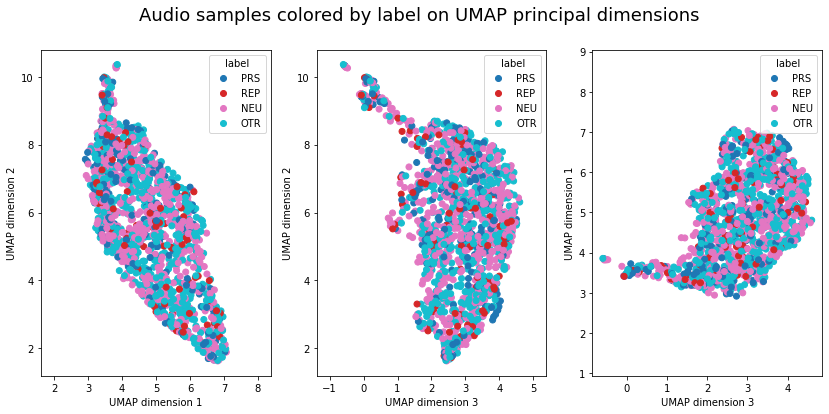

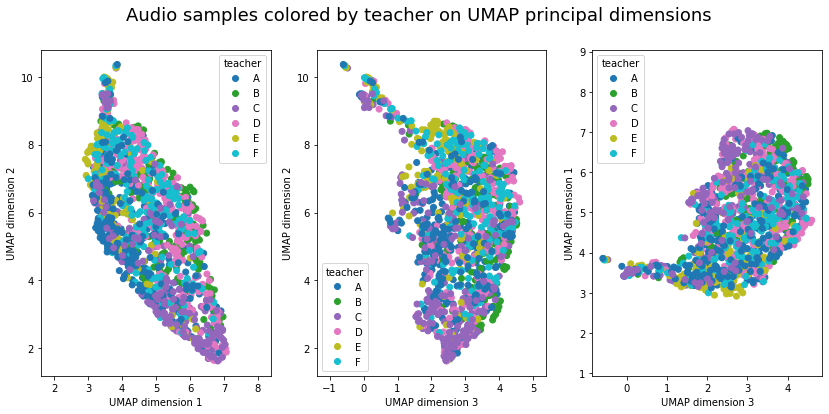

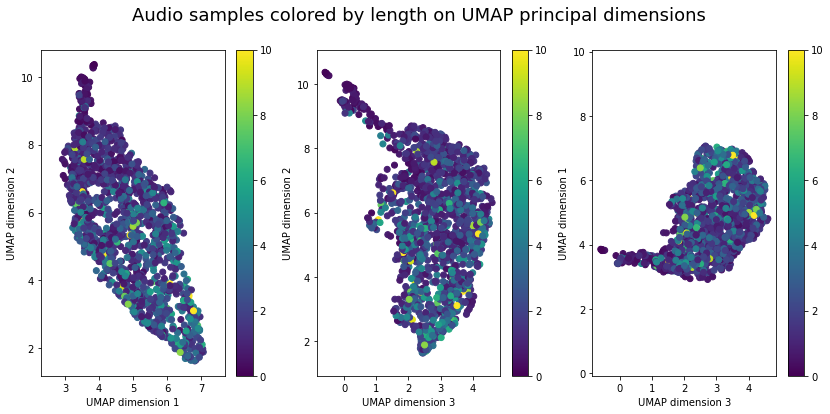

In [ ]:
#Generate fit with embeddings structure
umap_fit = get_umap_fit(embed_df, n_components=3, color_by='all', show_plots='2d', random_state=1234)

In [ ]:
umap_fit.embedding_.shape

(1450, 3)

# Simple k-means clustering
Here, we'll just implement an extra simple function which will allow us to see the clustering based on the number of clusters we select.  We'll color the output based on our interests.

In [ ]:
#export
def get_kmeans_clusters(data_df, cluster_data, k, show_plots=False):
    '''
    Function get_kmeans_clusters: performs k means clustering on data and returns model and data
        data_df: dataframe containing original data in same order as cluster_data
        cluster_data: numpy arrays with dimension samples x features to be clustered
        k: integer target number of clusters
        show_plots (default False): boolean of whether to show plots of the clusters along 1st and 2nd dimensions
        
        Returns scikit_learn kmeans model, copy of data_df with labels appended as the last column
    '''
    
    #define model specs
    kmeans_model = KMeans(n_clusters=k)
    
    #do the clustering
    kmeans_model.fit(cluster_data)
    
    #visualize clusters
    if show_plots:
        fig = plt.figure()
        emb_plt = plt.scatter(cluster_data[:,0], cluster_data[:,1], c=kmeans_model.labels_);
        plt.legend(*emb_plt.legend_elements());
        plt.xlabel('UMAP dimension 1');
        plt.ylabel('UMAP dimension 2');
        plt.title('Clustering of kmeans embeddings for k={}'.format(k), fontsize=18);
        plt.axis('equal')
        plt.gca().set_aspect('equal')
    
    #copy and append data
    ret_df = data_df.copy()
    ret_df['pred_cls'] = kmeans_model.labels_
    
    #return model
    return kmeans_model, ret_df

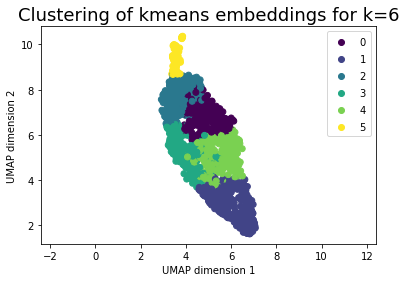

In [ ]:
km_mdl, datadf_labels = get_kmeans_clusters(embed_df, umap_fit.embedding_, 6, show_plots=True)

This isn't really bad just using visual inspection when compared to the real distributions of teachers in particular above!  Now that we've qualitatively inspected these results, we need to also inspect quantitatively.

In [ ]:
datadf_labels.head()

,id,transcript_filepath,wave_filename,speech,start_timestamp,end_timestamp,label,transcriber_id,last_hidden_state,last_hidden_state_mean,shape_state,start_milliseconds,end_milliseconds,length in seconds,Notes,Jess Labels,Unnamed: 9,Unnamed: 8,Notes - what I would code as,pred_cls
0,134-1,~/Box Sync/DSI Documents/cleaned_data/cleaned_...,~/Box Sync/DSI Documents/Audio Files & Tanscri...,good.,00:02.164,00:03.250,PRS,198,"[[-0.04940829798579216, 0.022830531001091003, ...","[-0.008398409001529217, 0.03857032582163811, -...","(54, 768)",2164,3250,1.086,NaN,NaN,NaN,NaN,NaN,3
1,134-1,~/Box Sync/DSI Documents/cleaned_data/cleaned_...,~/Box Sync/DSI Documents/Audio Files & Tanscri...,what's this word.,00:03.250,00:04.014,OTR,198,"[[0.16693411767482758, -0.08026503026485443, -...","[0.04827310889959335, 0.007540498394519091, -0...","(37, 768)",3250,4014,0.764,NaN,NaN,NaN,NaN,NaN,3
2,134-1,~/Box Sync/DSI Documents/cleaned_data/cleaned_...,~/Box Sync/DSI Documents/Audio Files & Tanscri...,SEE spells~,00:06.308,00:08.170,OTR,198,"[[0.021181466057896614, 0.03635687753558159, -...","[-0.040786080062389374, 0.023049458861351013, ...","(92, 768)",6308,8170,1.862,NaN,NaN,NaN,NaN,NaN,3
3,134-1,~/Box Sync/DSI Documents/cleaned_data/cleaned_...,~/Box Sync/DSI Documents/Audio Files & Tanscri...,what do you do with your eyes.,00:08.170,00:10.371,OTR,198,"[[-0.02607142925262451, 0.01225950662046671, 0...","[-0.013341954909265041, 0.0059876823797822, -0...","(109, 768)",8170,10371,2.201,NaN,NaN,NaN,NaN,NaN,3
4,134-1,~/Box Sync/DSI Documents/cleaned_data/cleaned_...,~/Box Sync/DSI Documents/Audio Files & Tanscri...,see.,00:12.000,00:13.473,NEU,198,"[[-0.02545803226530552, 0.05385156348347664, -...","[-0.04408932477235794, 0.021641386672854424, -...","(73, 768)",12000,13473,1.473,NaN,NaN,NaN,NaN,NaN,3


Fantastic.  We can use this dataframe in the future to inspect results.